In [1]:
# change working directory to the root of the project
import os
os.chdir('..')

In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import pyprotoevo

sim_name = 'gaia-seadra-voluptas'

In [4]:
sim_files = pyprotoevo.utils.SimulationFiles(sim_name)

In [5]:
import json


def read_json(path):
    with open(path) as f:
        return json.load(f)


stats_dir = sim_files.save_dir  / 'stats/summaries'
genomes_dir = sim_files.save_dir / 'stats/protozoa-genomes'

stats = {
    f.stem: read_json(f) for f in stats_dir.glob('*.json')
}

In [107]:
genomes = {
    f.stem: read_json(f) for i, f in enumerate(genomes_dir.glob('*.json'))
    if i % 25 == 0
}

: 

: 

In [6]:
all_stats = set(stat for time_stamp in stats for stat in stats[time_stamp]['stats'])

In [7]:
black_list = ['Node ', 'Organelle', 'Log', 'Molecule']
basic_stats = [
    stat for stat in all_stats
    if all(x not in stat for x in black_list)
]
print('\n'.join(basic_stats))

Plant to Digest Max
Available Energy Max
Max Plant Generation
Died from decay
Generation Min
Energy Limit Mean
Herbivore Factor Max
Energy Limit Max
Herbivore Factor Min
Available Energy Min
Generation Mean
Proxies
Repair Rate Min
Has Mated Min
Plant Digestion Rate Max
Num Cell Bindings Mean
Health Min
Num Engulfed Mean
Max Protozoa Generation
Bodies
Plant Digestion Rate Min
Health Mean
Health Max
Plant to Digest Min
Meat to Digest Mean
Meat Created
Multicell Structure Size Mean
Growth Rate Max
Speed Max
Num Engulfed Max
Multicell Structure Size Count
Died from the void
GRN Depth Min
Num Mutations Min
Construction Mass Mean
Died from being eaten
Mean Mutation Chance Max
Age Mean
Mean Mutation Chance Min
Plant to Digest Mean
Construction Mass Max
Death Rate Mean
Sleeping
Protozoa
Has Mated Mean
Meat Digestion Rate Mean
Herbivore Factor Mean
Meat to Digest Max
Light Sensitive Nodes Count
Available Energy Mean
Died from suffocation
Died from old age
Meat Digestion Rate Min
Has Mated Max
D

In [8]:
stat_types = {
    stat: record['unit']['units']
    for time_stamp in stats.keys()
    for stat, record in stats[time_stamp]['stats'].items()
    if record['unit'] is not None
}

In [9]:
def unit_to_string(unit: dict) -> str:
    '''
    Convert a unit dictionary to a string.
    For instance, {'MASS': 1, 'TIME': -1} becomes 'µg/s'.
    Possible base units are:
    - MASS: converted to micrograms (1e-6)
    - DISTANCE: converted to micrometers (1e-6)
    - TIME: converted to seconds (1)
    - ENERGY: converted to joules (1)
    - COUNT: converted to number (1)
    - ANGLE: converted to radians (1)
    - PERCENTAGE: converted to percentage (1)
    '''
    units = {
        'MASS': 'µg',
        'DISTANCE': 'µm',
        'TIME': 's',
        'ENERGY': 'J',
        'COUNT': '',
        'ANGLE': 'rad',
        'PERCENTAGE': '%'
    }
    return ''.join([
        units[key] + ('' if val == 1 else '^{' + str(val) + '}')
        for key, val in unit.items()
    ])

In [10]:
stat_type_strs = {
    stat: unit_to_string(unit)
    for stat, unit in stat_types.items()
}

In [11]:
def get_stat_value(stats, stat_name):
    return stats['stats'][stat_name]['value']

def get_stat_error(stats, stat_name):
    return stats['stats'][stat_name]['error']

In [12]:
from datetime import datetime

In [13]:
generation_df = pd.DataFrame([
    {
        'Time': datetime(*map(int, time_stamp.split('-'))),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in stats.items()
]);
generation_df['Wall Time'] = generation_df['Time'] - generation_df['Time'].min()
generation_df['Next Time Stamp'] = generation_df['Time Stamp'].shift(-1)
generation_df.head()

,Time,Time Stamp,Generation,Wall Time,Next Time Stamp
0,2023-03-05 16:52:35,2023-03-05-16-52-35,1,0 days 00:00:00,2023-03-05-16-59-20
1,2023-03-05 16:59:20,2023-03-05-16-59-20,2,0 days 00:06:45,2023-03-05-17-07-11
2,2023-03-05 17:07:11,2023-03-05-17-07-11,3,0 days 00:14:36,2023-03-05-17-15-02
3,2023-03-05 17:15:02,2023-03-05-17-15-02,3,0 days 00:22:27,2023-03-05-17-23-10
4,2023-03-05 17:23:10,2023-03-05-17-23-10,3,0 days 00:30:35,2023-03-05-17-31-25


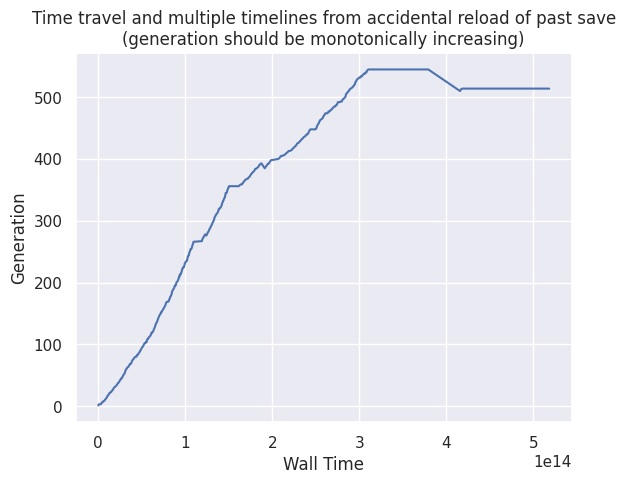

In [14]:
plt.title('Time travel and multiple timelines from accidental reload of past save\n(generation should be monotonically increasing)')
sns.lineplot(data=generation_df, x='Wall Time', y='Generation');

In [15]:
generation_df = generation_df.sort_values('Time Stamp')
records = generation_df.to_records()


def are_all_future_records_of_higher_generation(record):
    return all(
        record['Generation'] < records[i]['Generation']
        for i in range(record['index'] + 1, len(records))
    )


cleaned_stats = {
    (time_stamp := record['Time Stamp']) : stats[time_stamp]
    for record in records
    if are_all_future_records_of_higher_generation(record)
}

In [16]:
def get_datetime(time_stamp: str) -> datetime:
    return datetime(*map(int, time_stamp.split('-')))

In [17]:
generation_df_cleaned = pd.DataFrame([
    {
        'Time': get_datetime(time_stamp),
        'Time Stamp': time_stamp,
        'Generation': get_stat_value(stats_at_time, 'Max Protozoa Generation'),
    }
    for time_stamp, stats_at_time in cleaned_stats.items()
]);
generation_df_cleaned['Wall Time'] = generation_df_cleaned['Time'] - generation_df_cleaned['Time'].min()

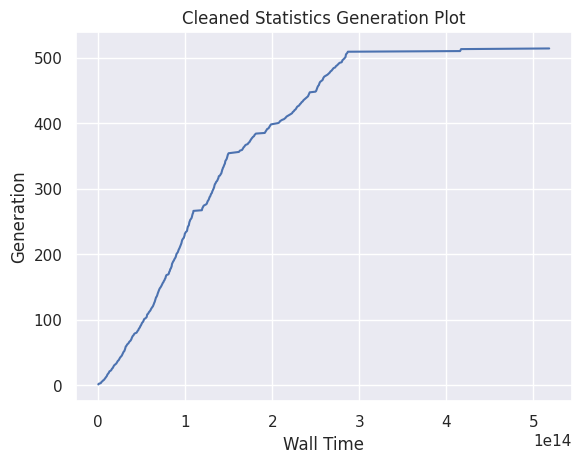

In [18]:
plt.title('Cleaned Statistics Generation Plot')
sns.lineplot(data=generation_df_cleaned, x='Wall Time', y='Generation');

In [19]:
stats = cleaned_stats

In [20]:
stats_df = pd.DataFrame([
    {
        stat: get_stat_value(stats[time_stamp], stat)
        for stat in basic_stats
        if stat in stats[time_stamp]['stats']
    }
    for time_stamp in stats.keys()
] + [
    {
        f'{stat} Error': get_stat_error(stats[time_stamp], stat)
        for stat in basic_stats
        if stat in stats[time_stamp]['stats']
    }
    for time_stamp in stats.keys()
])

import re

stat_names = {
    match.group(1) for stat in stats_df.columns 
    if (match := re.match(r'(.*) [Mean|Max|Min|Count]', stat))
    and 'Died' not in stat
}
print('\n'.join(stat_names))

# for stat in stats:
#     stats_df[stats_df[stat + 'Min']]

stats_df.fillna(0, inplace=True)
stats_df.replace(to_replace='NaN', value=np.nan, inplace=True)
stats_df.head()

Herbivore Factor
Light Sensitive Nodes
Has Mated
Meat to Digest
Num Spikes
Construction Mass
Growth Rate
Size
GRN Size
Available Energy
Death Rate
Num Engulfed
Health
Multicell Structure Size
Repair Rate
Total Mass
Mean Mutation Chance
Energy Limit
Meat
Plant to Digest
Split Radius
Protozoa
GRN Depth
Num Mutations
Meat Digestion Rate
Generation
Being Engulfed
Speed
Age
Construction Mass Limit
Num Cell Bindings
Plant Digestion Rate
Plants


,Max Plant Generation,Energy Limit Mean,Generation Mean,Proxies,Max Protozoa Generation,Bodies,Health Mean,Construction Mass Mean,Age Mean,Death Rate Mean,...,Total Mass Min Error,GRN Depth Max Error,Being Engulfed Max Error,Multicell Structure Size Min Error,Meat to Digest Min Error,GRN Size Min Error,Meat Digestion Rate Max Error,Generation Max Error,Energy Limit Min Error,Died from being healed to death?... Error
0,1.0,201.341741,1.000000,2511.0,1.0,2211.0,100.000000,0.010000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.0,169.549560,1.092715,4754.0,2.0,4603.0,38.183461,0.000038,19.546707,4.069189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.0,2056.707019,1.820513,4483.0,3.0,4444.0,69.316852,0.000432,21.353868,4.936097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.0,2079.916756,2.423729,4519.0,4.0,4460.0,66.293229,0.000275,20.862849,4.991800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32.0,2146.648119,3.254237,4502.0,5.0,4443.0,71.975710,0.000477,21.643576,5.151955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
attachment_types = {
    match.group(2) for stat in all_stats
    if (match := re.match(r'(.*): (.*) Construction Progress Mean', stat))
}
attachment_types

{'Binding', 'Flagellum', 'Phagocytic Receptor', 'Photoreceptor', 'Spike'}

In [22]:
node_prefixes = {
    match.group(1) for stat in all_stats
    if (match := re.match(r'(.*): (.*) Construction Progress Mean', stat))
}
node_prefixes

{'Node 0',
 'Node 1',
 'Node 10',
 'Node 11',
 'Node 2',
 'Node 3',
 'Node 4',
 'Node 5',
 'Node 6',
 'Node 7',
 'Node 8',
 'Node 9'}

In [23]:
def get_counts(search_term):
    photo_stats_df = pd.DataFrame([
        {'Generation': get_stat_value(stats[time_stamp], 'Max Protozoa Generation'), **{
            stat: get_stat_value(stats[time_stamp], stat)
            for stat in all_stats
            if search_term in stat and 'Count' in stat and stat in stats[time_stamp]['stats']
        }}
        for time_stamp in stats.keys()
    ])
    photo_stats_df.fillna(0, inplace=True)
    return photo_stats_df[[col for col in photo_stats_df.columns if search_term in col]].sum(axis=1)

In [24]:
# node stats only present with the corresponding attachment types
search_term_nodes = {
    'Red Light': 'Photoreceptor',
    'Thrust': 'Flagellum',
    'Engulfed Cells': 'Phagocytosis receptor',
    'Binding': 'Adhesion receptor',
}

for search_term in search_term_nodes:
    node_type = search_term_nodes[search_term]
    stats_df[f'{node_type} Count'] = get_counts(search_term)
    stat_names.add(node_type)

<AxesSubplot: xlabel='Max Protozoa Generation', ylabel='Protozoa'>

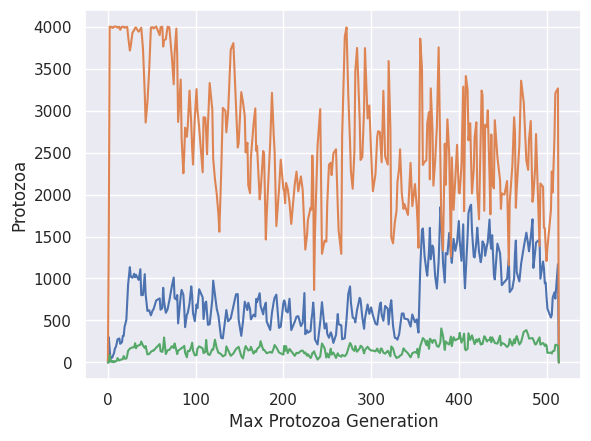

In [25]:
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Protozoa')
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Plants')
sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Meat Pellets')

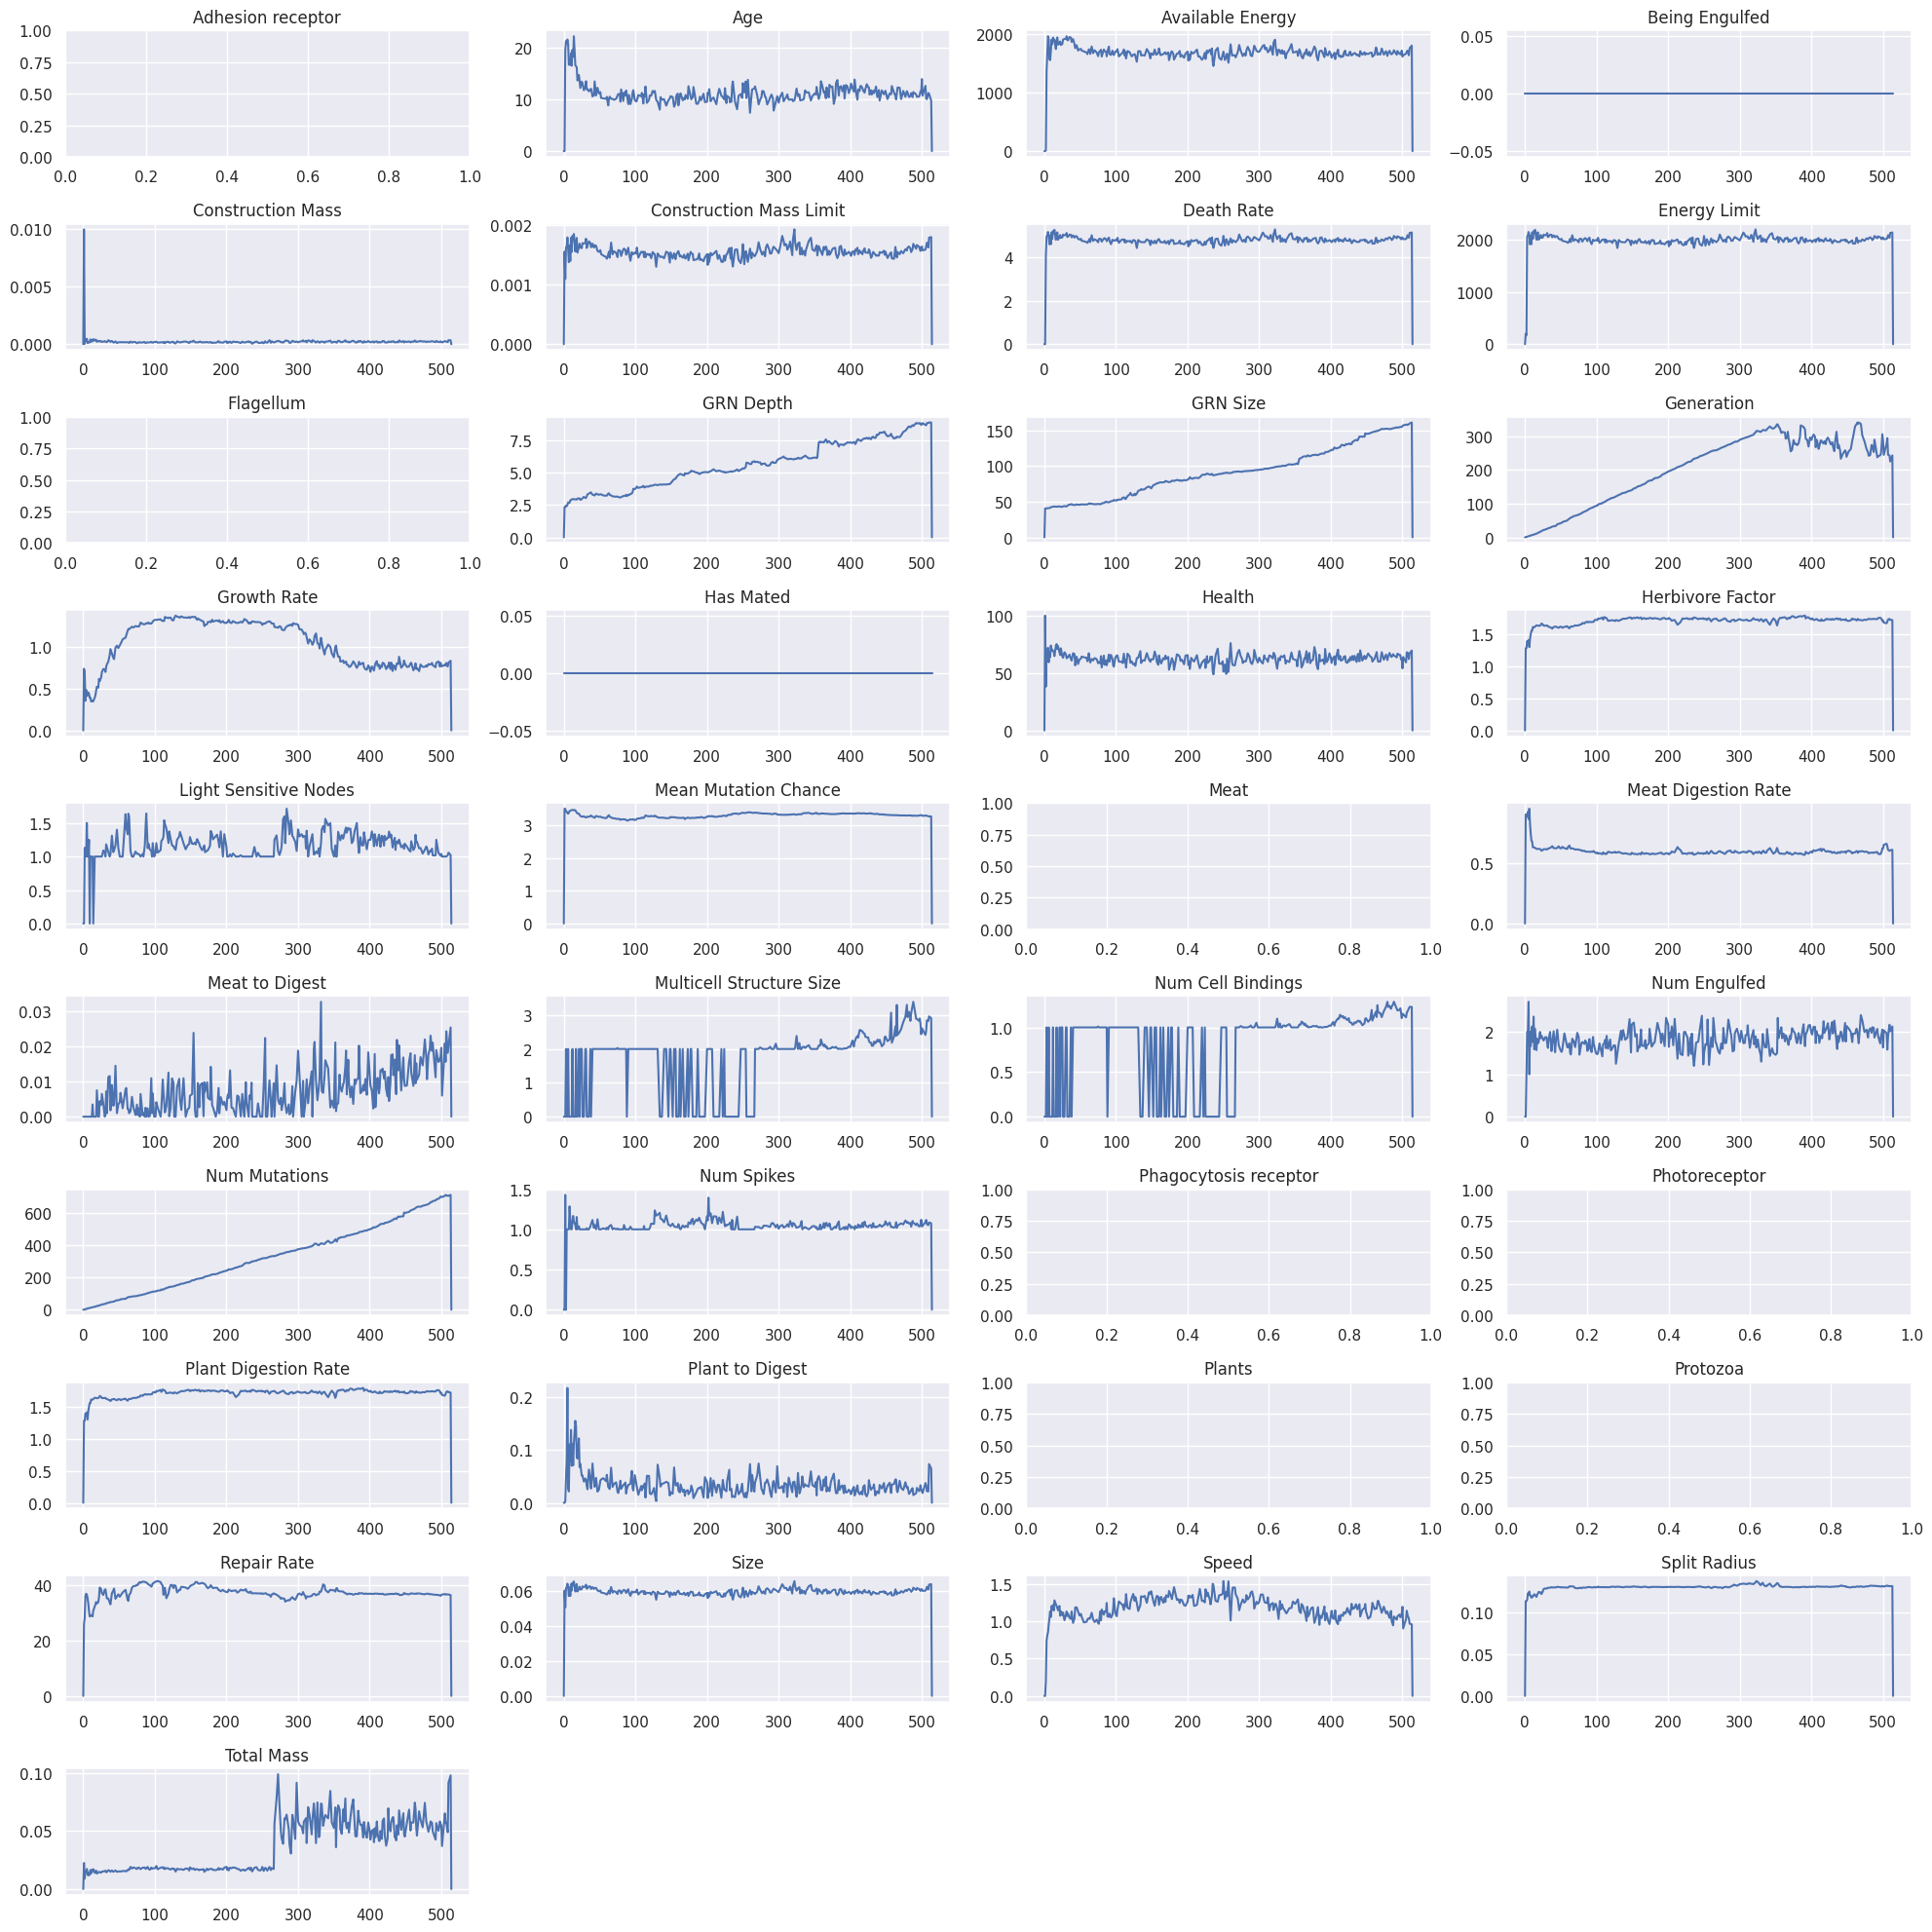

In [61]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
rows = int(np.ceil(len(stat_names) / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stat_names)):
    if stat is not None:
        # for stat_type in ['Min', 'Max', 'Mean']: 
        #     variable = f'{stat} {stat_type}'
        #     if variable in stats_df.columns:
        #         sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=variable, ax=ax)
        variable = f'{stat} Mean'
        if variable in stats_df.columns:
            sns_ax = sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=variable, ax=ax)
            if f'{stat} Error' in stats_df.columns:
                error = np.power(stats_df[stat + ' Error'], 2)
                lower = stats_df[variable] - error
                upper = stats_df[variable] + error
                sns_ax.fill_between(stats_df['Max Protozoa Generation'], lower, upper, alpha=0.2)
        ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')


plt.tight_layout()
plt.show()

In [26]:
for stat in stat_names:
    if stat + ' Count' in stats_df.columns:
        stats_df[stat + ' Frequency'] = stats_df[stat + ' Count'] / stats_df['Protozoa']

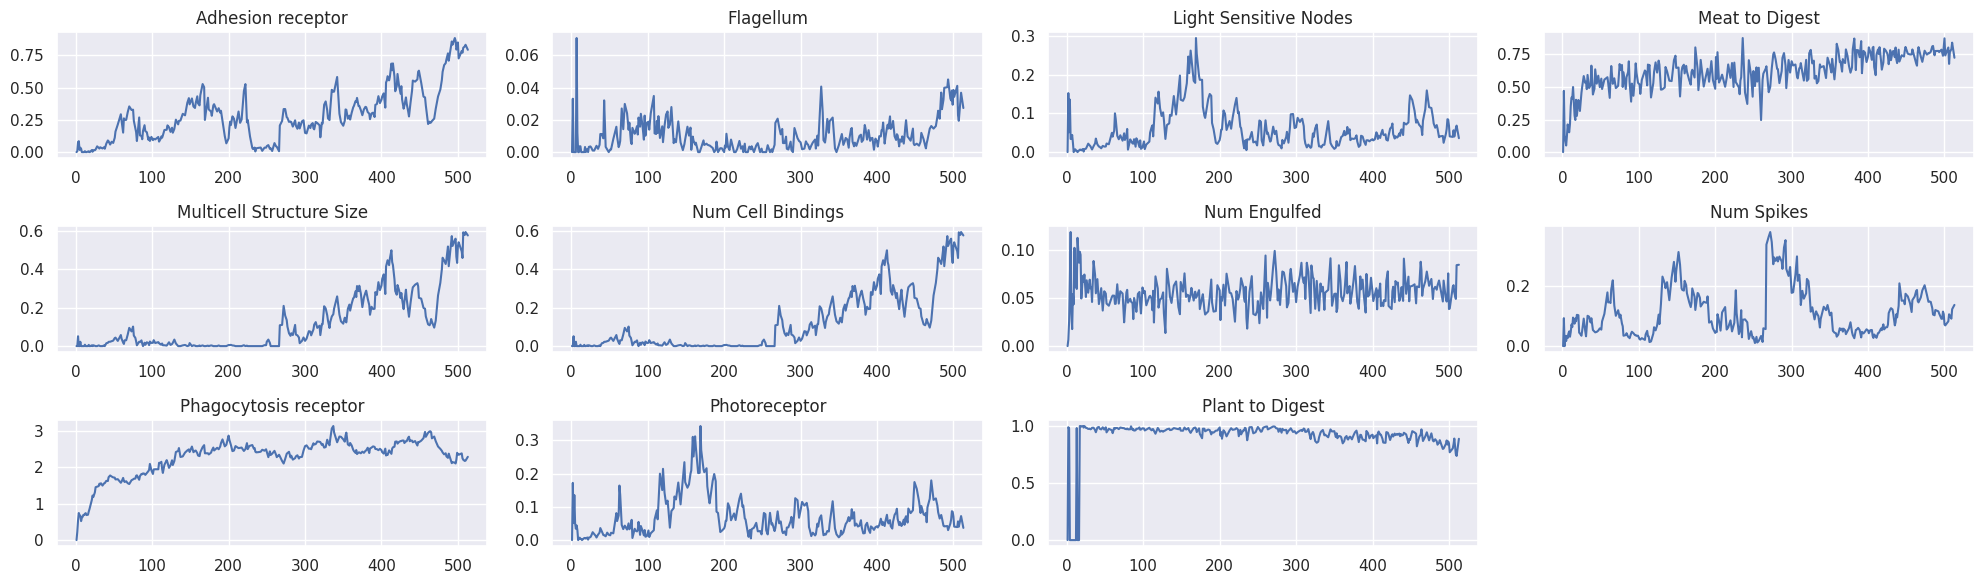

In [27]:
# n = int(np.ceil(np.sqrt(stats_df.columns.size)))
cols = 4
stats_with_counts = [stat for stat in stat_names if stat + ' Count' in stats_df.columns]
n_plots = len(stats_with_counts)
rows = int(np.ceil(n_plots / cols))


import itertools

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 2))
for ax, stat in itertools.zip_longest(axes.flatten(), sorted(stats_with_counts)):
    if stat is not None:
        variable = f'{stat} Frequency'
        if variable in stats_df.columns:
            sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=variable, ax=ax)
            ax.set_title(stat)
        ax.set_xlabel('')
        if stat in stat_type_strs and stat_type_strs[stat] != '':
            ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
        else:
            ax.set_ylabel('')
    else:
        ax.axis('off')


plt.tight_layout()
plt.show()

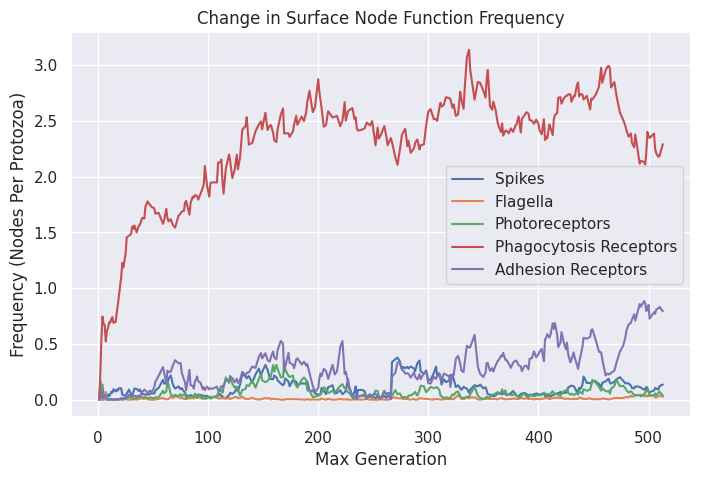

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))

labels_map = {
    # 'Multicell Structure Size': 'In Multicellular Structure',
    'Num Spikes': 'Spikes',
    'Flagellum': 'Flagella',
    'Photoreceptor': 'Photoreceptors',
    'Phagocytosis receptor': 'Phagocytosis Receptors',
    'Adhesion receptor': 'Adhesion Receptors',
}

for stat in labels_map:
    sns.lineplot(data=stats_df, x='Max Protozoa Generation', y=f'{stat} Frequency', ax=ax, label=labels_map[stat])

ax.set_ylabel('Frequency (Nodes Per Protozoa)')
ax.set_xlabel('Max Generation')
ax.set_title('Change in Surface Node Function Frequency')

plt.show()

# fig, ax = plt.subplots(figsize=(10, 5))
# sns.lineplot(data=stats_df, x='Max Protozoa Generation', y='Protozoa', ax=ax)
# ax.set_ylabel('Number of Protozoa')
# ax.set_xlabel('Max Generation')
# plt.show()

In [45]:
label = grid.get_xticklabels()[0]

In [47]:
label.get_label()

''

In [59]:
from itertools import combinations



[('Num Spikes', 'Flagellum'),
 ('Num Spikes', 'Photoreceptor'),
 ('Num Spikes', 'Phagocytosis receptor'),
 ('Num Spikes', 'Adhesion receptor'),
 ('Flagellum', 'Photoreceptor'),
 ('Flagellum', 'Phagocytosis receptor'),
 ('Flagellum', 'Adhesion receptor'),
 ('Photoreceptor', 'Phagocytosis receptor'),
 ('Photoreceptor', 'Adhesion receptor'),
 ('Phagocytosis receptor', 'Adhesion receptor')]

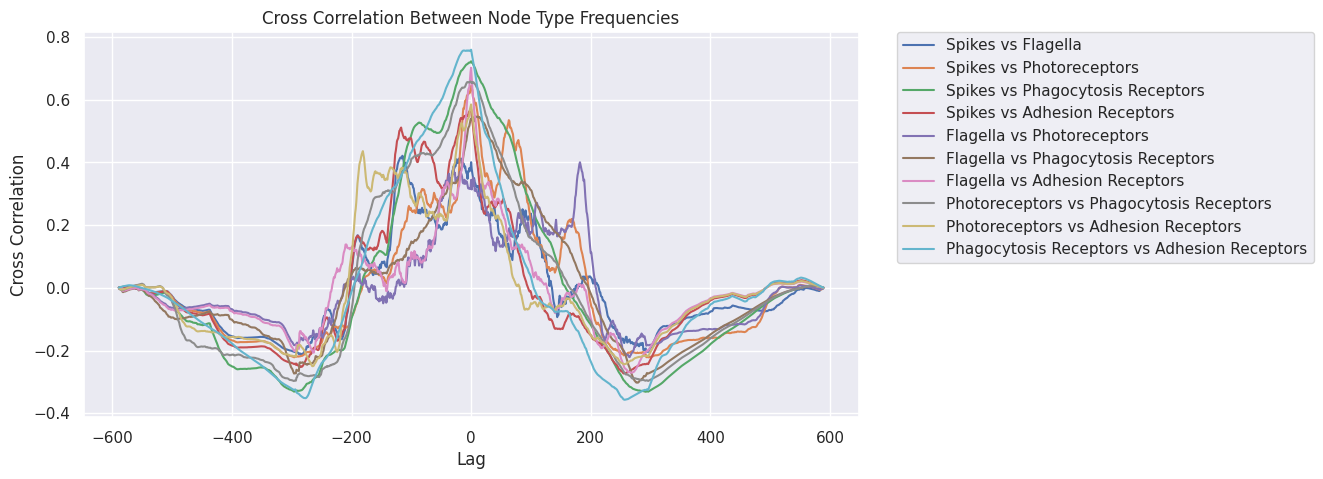

In [93]:
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
# cross_corrs = [
#     ccf_values(stats_df[f'{k1} Frequency'], stats_df[f'{k2} Frequency'])
#     for k1, k2 in combinations(labels_map, 2)
# ]

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f'Cross Correlation Between Node Type Frequencies')

# time = stats_df['Max Protozoa Generation']
# x = time - (time.max() - time.min()) // 2

for k1, k2 in combinations(labels_map, 2):
    # x = np.arange(cross_corrs[0].size)
    # y = cross_corrs[0]
    corr = ccf_values(stats_df[f'{k1} Frequency'].fillna(0), stats_df[f'{k2} Frequency'].fillna(0))
    x = np.arange(corr.size) - corr.size // 2
    ax.plot(x, corr, label=f'{labels_map[k1]} vs {labels_map[k2]}')
    ax.set_ylabel('Cross Correlation')
    ax.set_xlabel('Lag')

# legend outside of plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [57]:
grid = sns.heatmap(stats_df[[f'{stat} Frequency' for stat in labels_map]].corr(crosscorr).fillna(0))

# set rotation of xticklabels to 45 degrees
grid.set_xticklabels(labels_map.values(), rotation=25)
grid.set_yticklabels(labels_map.values())

plt.title('Pearson Correlation Between Frequencies of Node Types')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

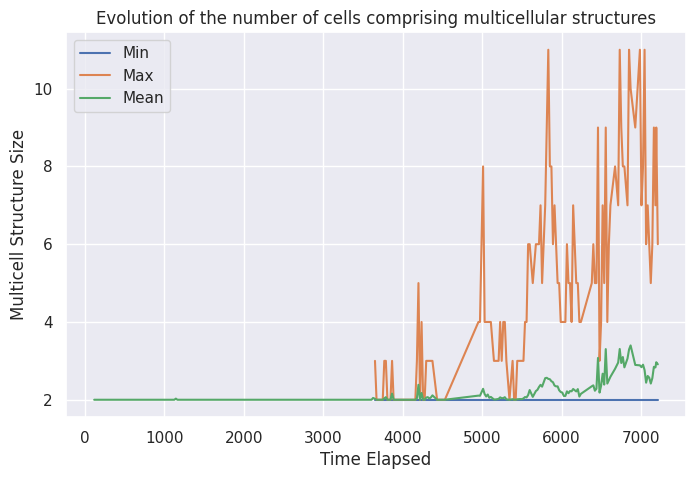

In [106]:
fig, ax = plt.subplots(figsize=(8, 5))

stat = 'Multicell Structure Size'
time_dim = 'Time Elapsed'

stat_df = stats_df[[f'{stat} {suffix}' for suffix in ['Min', 'Max', 'Mean']] + [time_dim]]

# is_nan = stat_df[stat + ' Min'].isna()
# stat_df[stat + ' Min'][is_nan] = stat_df[stat + ' Mean'][is_nan] 

for suffix in ['Min', 'Max', 'Mean']:
    not_zero = stat_df[f'{stat} {suffix}'] != 0  # zero values represent na values
    x = stat_df[time_dim][not_zero]
    sns.lineplot(x=x, y=stat_df[f'{stat} {suffix}'][not_zero], ax=ax, label=suffix)

if stat in stat_type_strs and stat_type_strs[stat] != '':
    ax.set_ylabel(f'${stat_type_strs[stat]}$'.replace('%', r'\%'))
else:
    ax.set_ylabel('')

# place legend outside of plot to the right
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel(time_dim)
ax.set_ylabel(stat)
ax.set_title('Evolution of the number of cells comprising multicellular structures')

plt.show()

In [32]:
def create_counts_df(time, genomes):
    df = pd.DataFrame([
        {'signature': gene['signature']}
        for genome in genomes
        for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
    ]).value_counts().reset_index().rename(columns={0: 'count'})
    df['time'] = time
    df['generation'] = get_stat_value(stats[time], 'Generation Mean')
    df['num_protozoa'] = get_stat_value(stats[time], 'Protozoa')
    df['frequency'] = df['count'] / df['num_protozoa']
    return df

gene_signatures_df = pd.concat([
    create_counts_df(time, genomes)
    for time, genomes in genomes.items()
    if time in stats
])

In [33]:
gene_signatures_df

,signature,count,time,generation,num_protozoa,frequency
0,-9223239949182548345,1,2023-03-05-16-52-35,1.00000,300,0.003333
1,3111382536755560872,1,2023-03-05-16-52-35,1.00000,300,0.003333
2,3108648323931458203,1,2023-03-05-16-52-35,1.00000,300,0.003333
3,3109380954978601831,1,2023-03-05-16-52-35,1.00000,300,0.003333
4,3109817975278749086,1,2023-03-05-16-52-35,1.00000,300,0.003333
...,...,...,...,...,...,...
5260,-557623118569254919,1,2023-03-08-18-45-11,261.55304,1546,0.000647
5261,-553528929150547899,1,2023-03-08-18-45-11,261.55304,1546,0.000647
5262,-551257698805789841,1,2023-03-08-18-45-11,261.55304,1546,0.000647
5263,-546041252897468814,1,2023-03-08-18-45-11,261.55304,1546,0.000647


In [34]:
variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(500))\
    .reset_index()
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,8194796692471825398,760917.0,193.508506,299632.333333,0.315165
1,-333445142389110449,760917.0,193.508506,299632.333333,0.315165
2,-4013311183576150124,760917.0,193.508506,299632.333333,0.315165
3,3711443662530888870,754887.0,193.508506,299632.333333,0.308484
4,-1252309653959324975,754887.0,193.508506,299632.333333,0.308484


In [35]:
high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(variance_df['signature'])]
# pivot signature to columns with fixation as values
high_var_genes_df_pivot = high_var_genes_df.pivot(index='generation', columns='signature', values='frequency')

In [36]:
reaches_high_freq = high_var_genes_df_pivot.max() >  0.85
reaches_high_freq_sigs = reaches_high_freq.index[reaches_high_freq.values].values

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


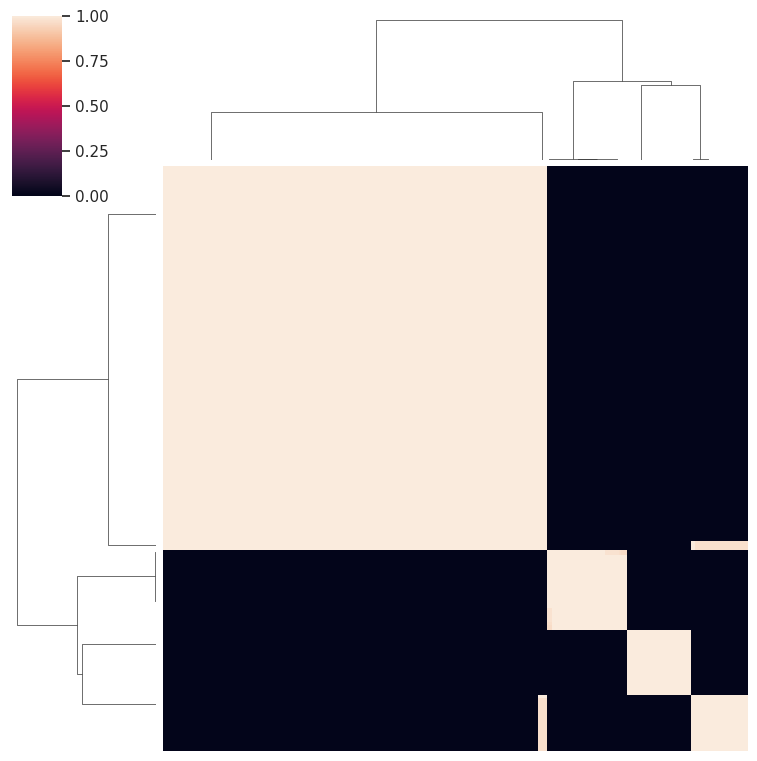

In [37]:
grid = sns.clustermap(high_var_genes_df_pivot.corr().fillna(0))
ax = grid.fig.axes[2]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [38]:
import scipy.cluster.hierarchy as spc

corr = high_var_genes_df_pivot.corr().fillna(0).values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.05 * pdist.max(), 'distance')
signature_clusters = dict(zip(high_var_genes_df_pivot.columns, idx))
clusters_ids = np.unique(idx)
clusters = {
    cluster_id: [
        signature for signature, cluster in signature_clusters.items()
        if cluster == cluster_id
    ]
    for cluster_id in clusters_ids
}
clusters_ids

array([1, 2, 3, 4, 5], dtype=int32)

In [39]:
def get_prototype(cluster_idx):
    signatures = [signature for signature, idx in signature_clusters.items() if idx == cluster_idx]
    cluster_df = variance_df[variance_df['signature'].isin(signatures)]
    return max(cluster_df.signature, key=lambda x: cluster_df[cluster_df['signature'] == x]['var frequency'].values[0])

cluster_prototypes = {
    cluster: get_prototype(cluster)
    for cluster in clusters
}

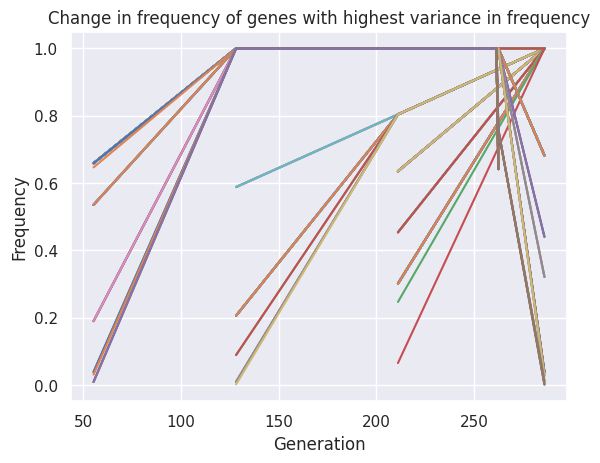

In [40]:
plot_sigs = high_var_genes_df['signature'][high_var_genes_df['signature'].isin(reaches_high_freq_sigs)].unique()

for gene in plot_sigs:
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

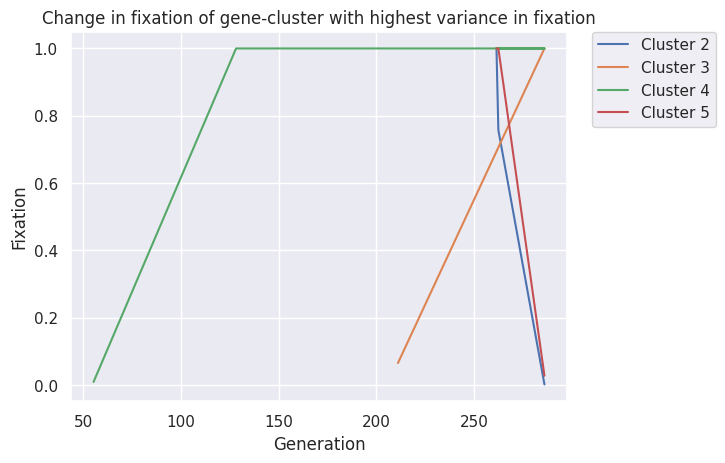

In [41]:
for cluster_id, gene in cluster_prototypes.items():
    if gene not in plot_sigs:
        continue
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'], label=f'Cluster {cluster_id}')
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of gene-cluster with highest variance in fixation')
# legend outside of plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [42]:
last_generation_time_stamp = max(genomes.keys(), key=get_datetime)
last_generation_time_stamp

last_generation_signatures = set([
    gene['signature']
    for genome in genomes[last_generation_time_stamp]
    for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
])

survived_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(last_generation_signatures)]
survived_genes_df.head()

,signature,count,time,generation,num_protozoa,frequency
0,1581485006197771189,427,2023-03-06-02-05-07,55.276235,648,0.658951
1,2615005743696135124,427,2023-03-06-02-05-07,55.276235,648,0.658951
2,7973029976515497682,427,2023-03-06-02-05-07,55.276235,648,0.658951
3,3975344228096951608,427,2023-03-06-02-05-07,55.276235,648,0.658951
4,-4650678076922969816,427,2023-03-06-02-05-07,55.276235,648,0.658951


In [43]:
survived_variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var frequency', ascending=False).dropna().take(range(500))\
    .reset_index()
survived_variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency
0,8194796692471825398,760917.0,193.508506,299632.333333,0.315165
1,-333445142389110449,760917.0,193.508506,299632.333333,0.315165
2,-4013311183576150124,760917.0,193.508506,299632.333333,0.315165
3,3711443662530888870,754887.0,193.508506,299632.333333,0.308484
4,-1252309653959324975,754887.0,193.508506,299632.333333,0.308484


In [44]:
survived_high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(survived_variance_df['signature'])]

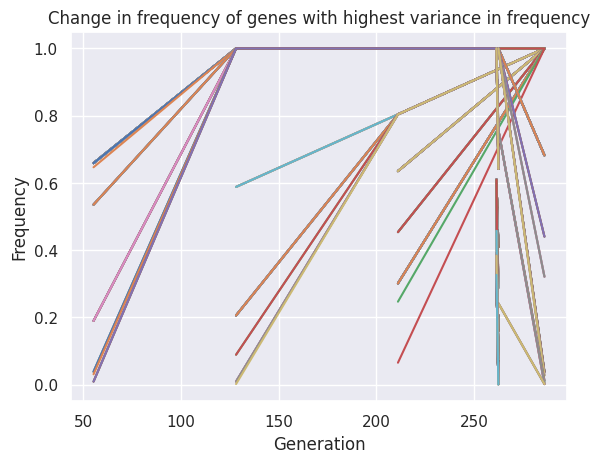

In [45]:
for gene in survived_high_var_genes_df['signature'].unique():
    gene_ts = survived_high_var_genes_df[survived_high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['frequency'])
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.title('Change in frequency of genes with highest variance in frequency')
plt.show()

In [46]:
variance_df['cluster id'] = variance_df['signature'].map(signature_clusters)
variance_df.head()

,signature,var count,var generation,var num_protozoa,var frequency,cluster id
0,8194796692471825398,760917.0,193.508506,299632.333333,0.315165,5
1,-333445142389110449,760917.0,193.508506,299632.333333,0.315165,5
2,-4013311183576150124,760917.0,193.508506,299632.333333,0.315165,5
3,3711443662530888870,754887.0,193.508506,299632.333333,0.308484,5
4,-1252309653959324975,754887.0,193.508506,299632.333333,0.308484,5


In [47]:
variance_df.groupby('cluster id').var()

,signature,var count,var generation,var num_protozoa,var frequency
cluster id,,,,,
1,2.965915e+37,1.245447e+10,0.000000e+00,0.000000e+00,0.002193
2,3.502486e+37,7.182401e+06,0.000000e+00,0.000000e+00,0.000009
3,2.982477e+37,1.799488e+09,2.045553e+06,1.529447e+08,0.002677
4,2.737548e+37,1.359901e+09,0.000000e+00,0.000000e+00,0.002646
5,2.692555e+37,3.129875e+10,4.316722e+02,1.026289e+09,0.013405
